### In this notebook we address state space models for a plasma physics experiment
The HITSI-U experiment relies on a set of four injectors, each with three circuit variables. The model for the circuit is the following state space model:
$$\dot{\mathbf x} = \mathbf A \mathbf x + \mathbf B \mathbf u,$$
$$\mathbf y = \mathbf C \mathbf x,$$
with the matrices defined below. In order to generate state space models that are
stable (even if there is substantial experimental noise), we need to constrain
the $\mathbf A$ matrix to be negative definite (note that if $\mathbf u = \mathbf K \mathbf x$ as in a Kalman filter, we only need the weaker condition that $\mathbf A + \mathbf{B}\mathbf K$ is negative definite). 

The optimization problem solved for provably stable linear models is described further in example7_reboot.ipynb in this same folder. 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7.3?filepath=examples/18_linear_stable_models/StateSpaceModel.ipynb)

In [5]:
# import libraries
import numpy as np
import pysindy as ps
from matplotlib import pyplot as plt
from scipy.signal import StateSpace, lsim, dlsim
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error

In [6]:
# Define the state space model parameters
Amplitude = 600
Amplitude1 = 600
Frequency = 19000  # injector frequency
RunTime = .004
SampleTime = 1e-7 
L1 = 8.0141e-7 # H
L2 = 2.0462e-6 # H
M = .161 * L2  # Coupling coefficient
Mw = .1346 * L2  # Coupling coefficient
Cap = 96e-6  # F
R1 = .0025  # Ohm
R2 = .005  # Ohm
R3 = .005  # Ohm
dT = 1e-7
PhaseAngle1 = 90
PhaseAngle2 = 180
PhaseAngle3 = 270

# Scale factor in front of the entries to the A matrix 
# that are affected by mutual inductance
scalar1 = 1 / ((L2 - Mw) * ( (L2 ** 2) - (4 * M ** 2)  +  2 *L2 * Mw +  (Mw ** 2) ))
x3a =  (-L2 ** 2) * R2 + (2 * M ** 2) * R2 -L2 * Mw * R2
x3b = (-L2 ** 2) + (2 * M ** 2)-L2 * Mw
x3c = (L2 ** 2) * R2 - (2 * M ** 2) * R2 + L2 * Mw * R2 + (L2 ** 2) * R3 - (2 * M ** 2) * R3 + L2 * Mw * R3
x3d = L2 * M * R2 - M * Mw * R2
x3e = L2 * M- M * Mw
x3f = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3g = L2 * M * R2 - M * Mw * R2
x3h = L2 * M- M * Mw
x3i = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3j = - 2 * (M ** 2) * R2 + L2 * Mw * R2 + (Mw ** 2) * R2
x3k = - 2 * (M ** 2) + L2 * Mw + Mw ** 2
x3l = 2 * (M ** 2) * R2 -L2 * Mw * R2 - (Mw ** 2) * R2 + 2 * R3 * (M ** 2)-L2 * Mw * R3 - R3 * Mw ** 2

# Entries for x6 in A matrix
x6a = -L2 * M * R2 + M * Mw * R2
x6b = -L2 * M + M * Mw
x6c = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3
x6d = R2 * (L2 ** 2)- 2 * R2 * (M ** 2) + L2 * Mw * R2
x6e = (L2 ** 2)- 2 * (M ** 2) + L2 * Mw
x6f = - R2 * (L2 ** 2) + 2 * R2 * (M ** 2)-L2 * Mw * R2 - R3 * (L2 ** 2) + 2 * R3 * (M ** 2)-L2 * Mw * R3
x6g = 2 * R2 * (M ** 2)-L2 * Mw * R2 - R2 * (Mw ** 2)
x6h = 2 * (M ** 2)-L2 * Mw- (Mw ** 2)
x6i = - 2 * R2 * (M ** 2) + L2 * Mw * R2 + R2 * (Mw ** 2)- 2 * R3 * (M ** 2) + L2 * Mw * R3 + R3 * (Mw ** 2)
x6j = -L2 * M * R2 + M * Mw * R2
x6k = -L2 * M + M * Mw
x6l = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3

# Entries for x9 in A matrix
x9a = -L2 * M * R2  +  M * Mw * R2
x9b = -L2 * M  +  M * Mw
x9c = L2 * M * R2 - M * Mw * R2 *  +  L2 * M * R3  - M * Mw * R3
x9d = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2
x9e = 2 * (M ** 2) - L2 * Mw - (Mw ** 2)
x9f = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  +  (Mw ** 2) * R2 - 2 * (M ** 2) * R3  +  L2 * Mw * R3  +  (Mw ** 2) * R3
x9g =(L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2
x9h = (L2 ** 2) - 2 * (M ** 2)  +  L2 * Mw
x9i = - (L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2 - (L2 ** 2) * R3  +  2 * (M ** 2) * R3 - L2 * Mw * R3
x9j = -L2 * M * R2  +  M * Mw * R2
x9k = -L2 * M  +  M * Mw 
x9l = L2 * M * R2 - M * Mw * R2  +  L2 * M * R3 - M * Mw * R3

#Entries for x12 in A matrix
x12a = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  + (Mw ** 2) * R2
x12b = - 2 * (M ** 2)  +  L2 * Mw  +  (Mw ** 2)
x12c = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2  +  2 * (M ** 2) * R3 - L2 * Mw * R3 - (Mw ** 2) * R3
x12d = L2 * M * R2 - M * Mw * R2
x12e = L2 * M - M * Mw
x12f = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12g = L2 * M * R2 - M * Mw * R2
x12h = L2 * M - M * Mw
x12i = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12j = (-L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2
x12k = (-L2 ** 2)  +  2 * (M ** 2) - L2 * Mw
x12l = (L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2  +  (L2 ** 2) * R3 - 2 * (M ** 2) * R3  +  L2 * Mw * R3

### Finally, define the state space matrices

In [7]:
A = np.array([[((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [1 / Cap, 0, -1 / Cap, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [-scalar1 * x3a, -scalar1 * x3b,-scalar1 * x3c, -scalar1 * x3d, 
      -scalar1 * x3e, -scalar1 * x3f, -scalar1 * x3g, -scalar1 * x3h, 
      -scalar1 * x3i, -scalar1 * x3j, -scalar1 * x3k, -scalar1 * x3l],
     [0, 0, 0, ((-1 / L1)*(R1 + R2)), -1 / L1, R2*1 / L1, 0, 0, 0, 0, 0, 0], 
     [0, 0, 0,  1 / Cap, 0, -1 / Cap, 0, 0, 0, 0, 0, 0], 
     [scalar1 * x6a, scalar1 * x6b, scalar1 * x6c, scalar1 * x6d, 
      scalar1 * x6e, scalar1 * x6f, scalar1 * x6g, scalar1 * x6h, 
      scalar1 * x6i, scalar1 * x6j, scalar1 * x6k, scalar1 * x6l],
     [0, 0, 0, 0, 0, 0, ((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1, 0, 0, 0], 
     [0, 0, 0, 0, 0, 0, 1 / Cap, 0, -1 / Cap, 0, 0, 0], 
     [scalar1 * x9a, scalar1 * x9b, scalar1 * x9c, scalar1 * x9d, 
      scalar1 * x9e, scalar1 * x9f, scalar1 * x9g, scalar1 * x9h, 
      scalar1 * x9i, scalar1 * x9j, scalar1 * x9k, scalar1 * x9l], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, ((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1 / Cap, 0, -1 / Cap], 
     [-scalar1 * x12a, -scalar1 * x12b, -scalar1 * x12c, -scalar1 * x12d,
      -scalar1 * x12e, -scalar1 * x12f, -scalar1 * x12g, -scalar1 * x12h, 
      -scalar1 * x12i, -scalar1 * x12j, -scalar1 * x12k, -scalar1 * x12l]]
)

B = np.array(
    [[1 / L1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 1 / L1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1 / L1, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1 / L1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]]
)

C = np.array(
    [[0,0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
)

D = np.zeros((C.shape[0], C.shape[0]))

sysc = StateSpace(A, B, C, D) 
print(A.shape, C.shape, B.shape, D.shape)
print(np.linalg.eigvals(A)) 

(12, 12) (4, 12) (12, 4) (4, 4)
[-5374.04778628+128310.86801552j -5374.04778628-128310.86801552j
 -6150.9991369 +138653.66264826j -6150.9991369 -138653.66264826j
 -6044.9626896 +137273.04653728j -6044.9626896 -137273.04653728j
 -6044.96263763+137273.04653074j -6044.96263763-137273.04653074j
 -2052.57854051     +0.j         -2915.80446125     +0.j
 -2915.80452169     +0.j         -2983.64806906     +0.j        ]


#### Notice the A matrix has all negative eigenvalues, as it must!

### Load in the voltage control inputs
These are square waves at some pre-defined injector frequency.

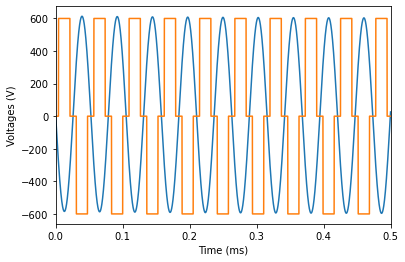

In [8]:
time = np.linspace(0, RunTime, int(RunTime / SampleTime) + 1, endpoint=True)
data = loadmat('voltages.mat')
voltage1 = data['voltage']
voltage2 = data['newVoltageShift1']
voltage3 = data['newVoltageShift2']
voltage4 = data['newVoltageShift3']
plt.plot(time * 1e3, voltage1)
plt.plot(time * 1e3, voltage3)
plt.xlim(0, 0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Voltages (V)')
plt.show()

Text(0, 0.5, '$x_i(t)$')

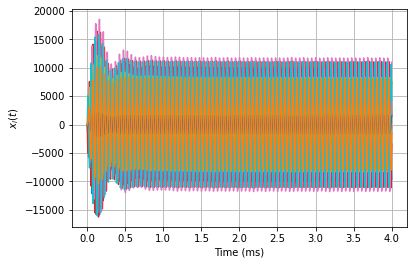

In [9]:
tout, yout, xout = lsim(
    sysc, 
    np.hstack([voltage1, voltage2, voltage3, voltage4]), 
    time
)

# Add some noise proportional to the signal with the smallest amplitude of the 12
rmse = mean_squared_error(xout[:, 1], np.zeros(xout[:, 1].shape), squared=False)
xout = xout + np.random.normal(0, rmse / 100.0 * 0.1, xout.shape)  # add modest 0.1% noise

# Could consider rescaling units here
# xout = xout
# yout = yout
# tout = tout 
# dt = tout[1] - tout[0]
for i in range(12):
    plt.plot(tout * 1000, xout[:, i])
plt.grid(True)
plt.xlabel('Time (ms)')
plt.ylabel(r'$x_i(t)$')

### Discover the dx/dt = Ax + Bu part of the state space model
Try STLSQ instead -- you will likely get an unstable model! Below we use a special optimizer to make sure the linear matrix is stable. $\nu \ll 1$ promotes stability.

In [10]:
# Define the control input
u = np.hstack([voltage1, voltage2, voltage3, voltage4])
sindy_library = ps.PolynomialLibrary(degree=1, include_bias=False)
optimizer_stable = ps.StableLinearSR3(
    threshold=0.0,
    thresholder='l1',
    nu=1e-5,
    max_iter=1000,
    tol=1e-5,
    verbose=True,
)

model = ps.SINDy(feature_library=sindy_library, optimizer=optimizer_stable)
model.fit(xout, t=tout, u=u)

 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)
         0 ... 2.9905e+25 ... 1.7537e+18 ... 0.0000e+00 ... 2.9905e+25
       100 ... 2.9171e+25 ... 1.5300e+18 ... 0.0000e+00 ... 2.9171e+25
       200 ... 2.9171e+25 ... 1.5300e+18 ... 0.0000e+00 ... 2.9171e+25
       300 ... 2.9171e+25 ... 1.5300e+18 ... 0.0000e+00 ... 2.9171e+25
       400 ... 2.9171e+25 ... 1.5300e+18 ... 0.0000e+00 ... 2.9171e+25
       500 ... 2.9171e+25 ... 1.5300e+18 ... 0.0000e+00 ... 2.9171e+25
       600 ... 2.9171e+25 ... 1.5300e+18 ... 0.0000e+00 ... 2.9171e+25
       700 ... 2.9171e+25 ... 1.5300e+18 ... 0.0000e+00 ... 2.9171e+25
       800 ... 2.9171e+25 ... 1.5300e+18 ... 0.0000e+00 ... 2.9171e+25
       900 ... 2.9171e+25 ... 1.5300e+18 ... 0.0000e+00 ... 2.9171e+25


C:\Users\ducks\pysindy\pysindy\optimizers\stable_linear_sr3.py:431: ConvergenceWarning: StableLinearSR3._reduce did not converge after 1000 iterations.
  warnings.warn(


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=1, include_bias=False),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
                     'x10', 'x11', 'u0', 'u1', 'u2', 'u3'],
      optimizer=StableLinearSR3(max_iter=1000, nu=1e-05, threshold=0.0,
                                verbose=True))

### Without noise, can match A and B matrices quite well

In [11]:
Xi = model.coefficients()
r = Xi.shape[0]
B_SINDy = Xi[:r, r:]
A_SINDy = Xi[:r, :r]

def normalized_error(matrix_true, matrix_pred):
    return np.linalg.norm(matrix_true - matrix_pred) / np.linalg.norm(matrix_true)
    
print(normalized_error(A, A_SINDy))
print(normalized_error(B, B_SINDy))

0.19040772818915858
0.20687676667808547


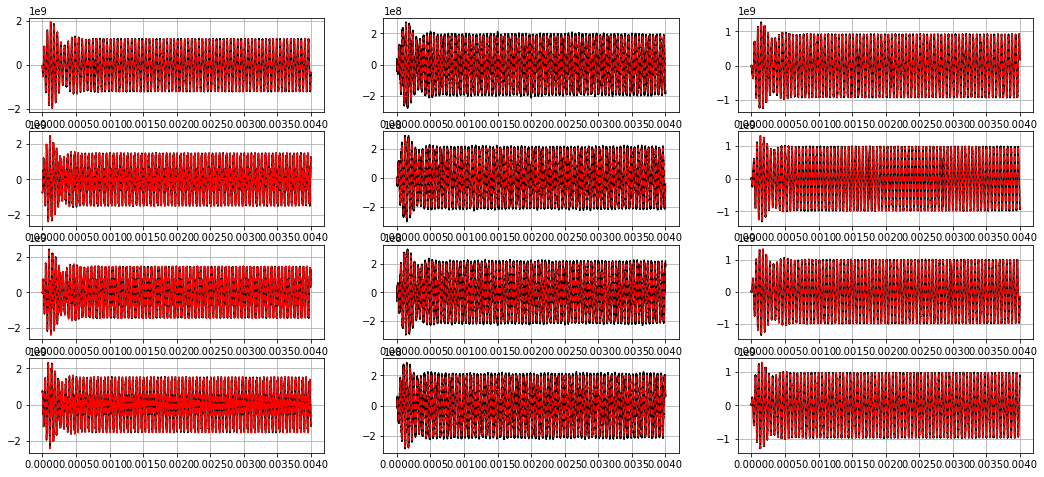

In [12]:
ydot_true = model.differentiate(xout, t=tout)
ydot_pred = model.predict(xout, u=u)
plt.figure(figsize=(18, 8))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.grid(True)
    plt.plot(tout, ydot_true[:, i], 'k')
    plt.plot(tout, ydot_pred[:, i], 'r--')

### Check if the A matrix is negative definite!
If not all the eigenvalues are negative, model is eventually unstable. If so, optimize with the StableLinearOptimizer until the eigenvalues are pushed to be all negative. 

In [13]:
Xi = model.coefficients()
print(np.sort(np.linalg.eigvals(Xi[:12, :12])))

[-6941.89037323     +0.j         -6533.77368759-136451.77974792j
 -6533.77368759+136451.77974792j -5581.63482558-132301.57675488j
 -5581.63482558+132301.57675488j -4891.82416115-141377.58267624j
 -4891.82416115+141377.58267624j -3125.91094321     +0.j
 -1996.64418558  -2136.50106493j -1996.64418558  +2136.50106493j
 -1044.22258314-116972.77783533j -1044.22258314+116972.77783533j]


### Now try resimulating the training data from some new initial condition
This is a 12D system and the time base is VERY well-sampled so integration might take a while!

In [14]:
x0_new = (np.random.rand(12) - 0.5) * 10000 
tout, yout, xout = lsim(
    sysc, 
    u, 
    time,
    X0=x0_new,
)
x_pred = model.simulate(
    x0_new, 
    t=tout[:int(len(tout) // 2):10], 
    u=u[:int(len(tout) // 2):10, :]
)

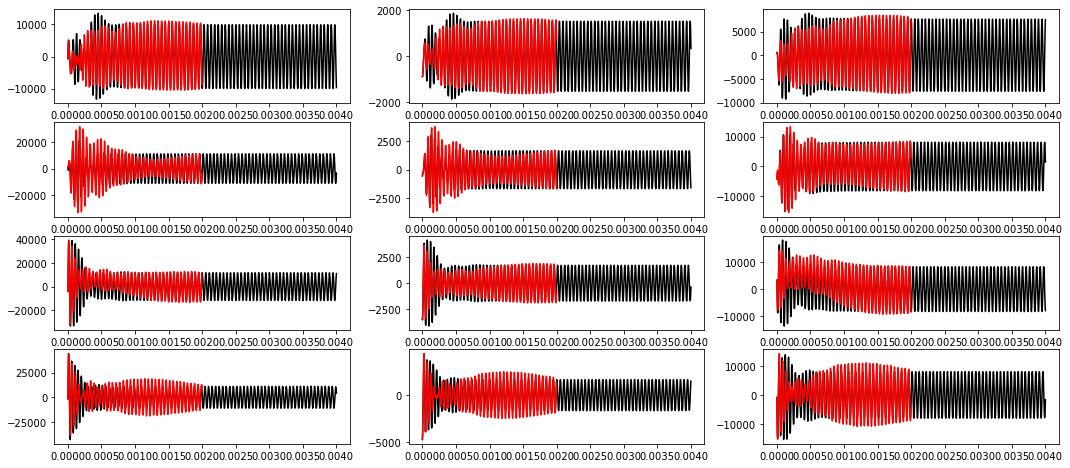

In [15]:
plt.figure(figsize=(18, 8))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.plot(time, xout[:, i], 'k')
    plt.plot(tout[:int(len(tout) // 2) - 10:10], x_pred[:, i], 'r')